In [9]:
import joblib
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


df = joblib.load("/home/lavrenchuk/TS_Project_Favorita/data/processed/features_agg.joblib")
print(df.shape)
print(df.index.min(), df.index.max())
display(df.tail())

(1687, 23)
2013-01-02 00:00:00 2017-08-15 00:00:00


,unit_sales,unit_sales_log,month,day_of_month,weekday,is_workday,lag_log_1,lag_log_7,lag_log_14,lag_log_28,...,roll_mean_56,roll_std_7,roll_std_28,dow_sin,dow_cos,year_sin,year_cos,is_holiday,before_holiday,after_holiday
date,,,,,,,,,,,,,,,,,,,,,
2017-08-11,80783.227,11.299537,8,11,4,1,10.984767,11.172635,11.192696,11.086023,...,11.230961,0.204764,0.185977,-0.433884,-0.900969,-0.866025,-0.5,0,0,1
2017-08-12,77928.860,11.263564,8,12,5,0,11.299537,11.399004,11.469589,11.365008,...,11.233187,0.206186,0.183745,-0.974928,-0.222521,-0.866025,-0.5,0,0,0
2017-08-13,92090.859,11.430542,8,13,6,0,11.263564,11.571467,11.615288,11.574843,...,11.229576,0.193813,0.182363,-0.781831,0.623490,-0.866025,-0.5,0,0,0
2017-08-14,69852.929,11.154162,8,14,0,1,11.430542,11.195912,11.342291,11.196703,...,11.230797,0.153342,0.174573,0.000000,1.000000,-0.866025,-0.5,0,1,0
2017-08-15,80080.046,11.290794,8,15,1,1,11.154162,11.110238,11.509225,11.098969,...,11.229696,0.153969,0.175148,0.781831,0.623490,-0.866025,-0.5,1,0,0


## Prophet

Test period: 2017-05-18 00:00:00 → 2017-08-15 00:00:00


23:12:56 - cmdstanpy - INFO - Chain [1] start processing
23:12:56 - cmdstanpy - INFO - Chain [1] done processing


К-сть майбутніх точок: 90

Forecast 30 days:
           ds       yhat  yhat_lower  yhat_upper
0  2017-05-18  10.974566   10.035707   11.845507
1  2017-05-19  11.060632   10.049001   12.045403
2  2017-05-20  11.408377   10.433349   12.334491
3  2017-05-21  11.394949   10.422122   12.374716
4  2017-05-22  11.232082   10.204036   12.144295
5  2017-05-23  11.165020   10.261300   12.091410
6  2017-05-24  11.104501   10.144860   12.070895
7  2017-05-25  10.962391   10.032542   11.933372
8  2017-05-26  11.054709   10.122751   11.991483
9  2017-05-27  11.409010   10.501302   12.386493
10 2017-05-28  11.402218   10.394901   12.284226
11 2017-05-29  11.245839   10.270634   12.073504
12 2017-05-30  11.184895   10.222002   12.086472
13 2017-05-31  11.129920   10.198845   12.020227
14 2017-06-01  10.992590    9.992368   11.960386
15 2017-06-02  11.088765   10.121626   11.999887
16 2017-06-03  11.445870   10.505426   12.335303
17 2017-06-04  11.440735   10.446462   12.303341
18 2017-06-05  11.284812

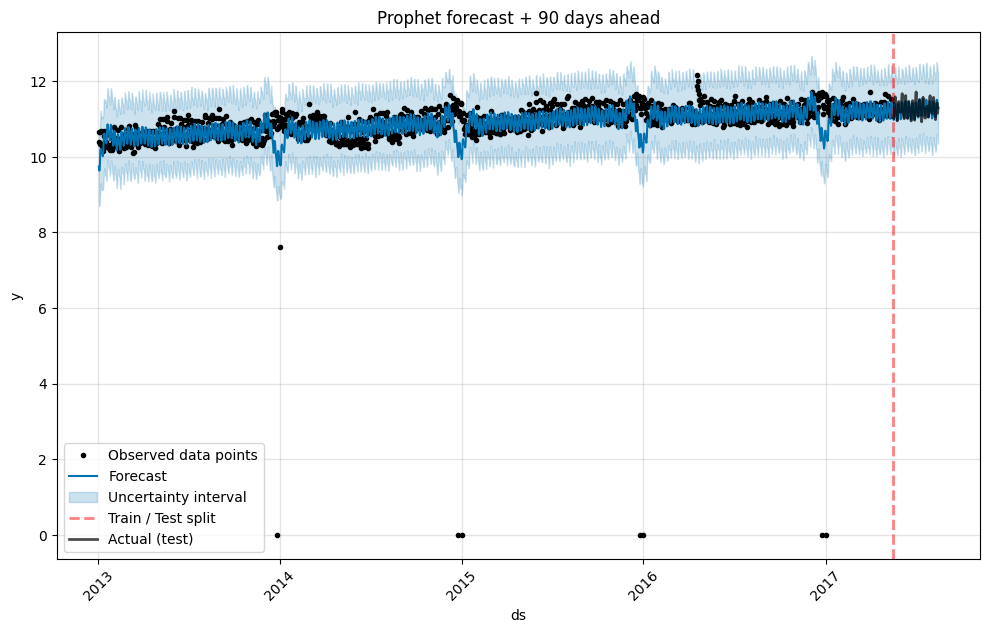

Test-set metrics:
MAE  = 0.1011
RMSE = 0.1242
MAPE = 0.90%


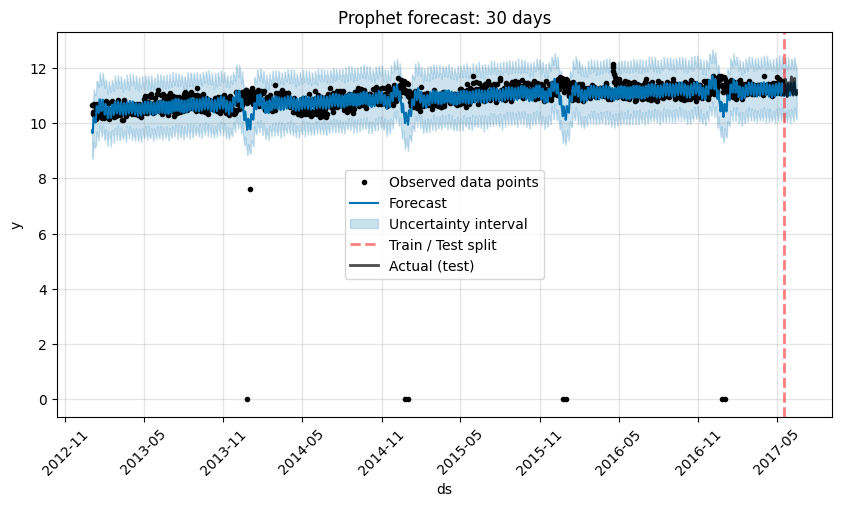

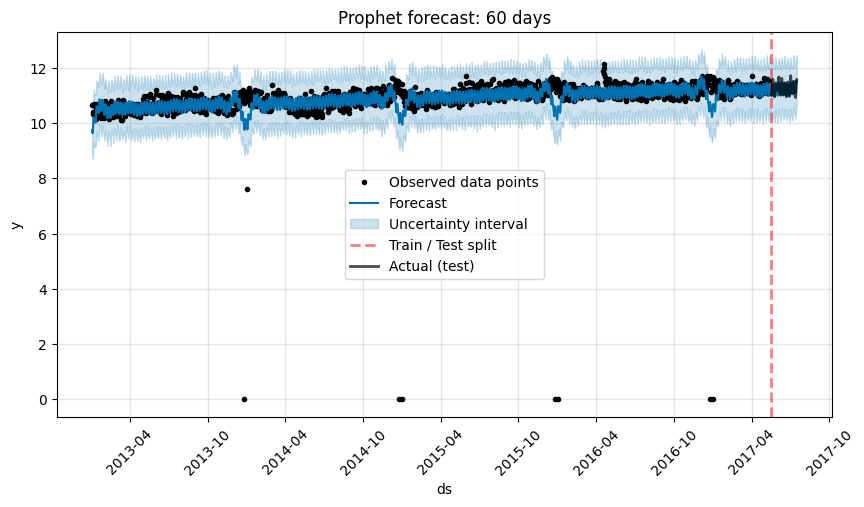

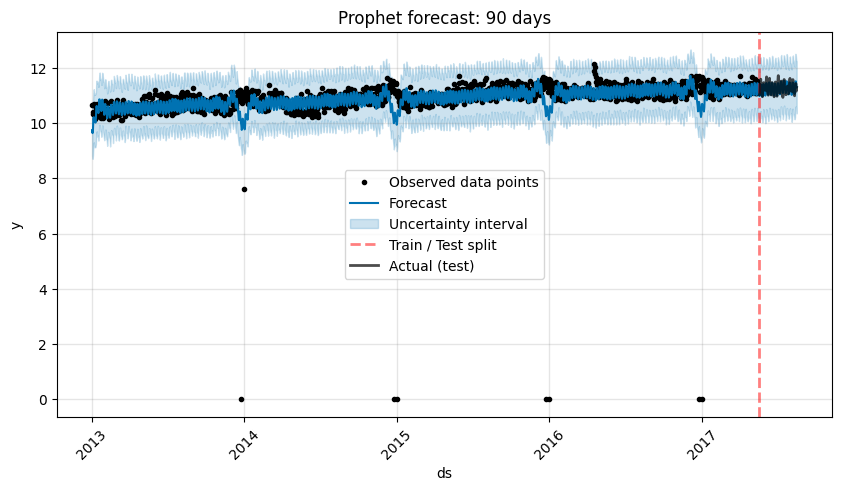

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet  

df_prophet = df.copy()


df_prophet = df_prophet.reset_index().rename(columns={
    'date': 'ds',          
    'unit_sales_log': 'y'  
})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


train, test = df_prophet[:-90], df_prophet[-90:]
print("Test period:", test['ds'].min(), "→", test['ds'].max())


model = Prophet(
    daily_seasonality=False,  
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(train)


future = model.make_future_dataframe(periods=90, freq='D')  
forecast = model.predict(future)

forecast_future = forecast[forecast['ds'] > train['ds'].max()].copy()
forecast_future = forecast_future.sort_values('ds').reset_index(drop=True)

print("К-сть майбутніх точок:", len(forecast_future))

forecast_30 = forecast_future.iloc[:30].copy()
forecast_60 = forecast_future.iloc[:60].copy()
forecast_90 = forecast_future.iloc[:90].copy()

print("\nForecast 30 days:")
print(forecast_30[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

print("\nForecast 60 days:")
print(forecast_60[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

print("\nForecast 90 days:")
print(forecast_90[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


fig = model.plot(forecast)
plt.axvline(x=train['ds'].max(), c='red', lw=2, alpha=.5, ls='--', label='Train / Test split')


plt.plot(test['ds'], test['y'], c='black', lw=2, alpha=.7, label='Actual (test)')
plt.xticks(rotation=45)
plt.legend()
plt.title('Prophet forecast + 90 days ahead')
plt.show()


def plot_horizon(forecast_h, horizon_label):
    plt.figure(figsize=(10, 5))
    
    sub = forecast[forecast['ds'] <= forecast_h['ds'].max()]
    model.plot(sub, ax=plt.gca())
    plt.axvline(x=train['ds'].max(), c='red', lw=2, alpha=.5, ls='--', label='Train / Test split')
    
    test_sub = test[test['ds'] <= forecast_h['ds'].max()]
    if not test_sub.empty:
        plt.plot(test_sub['ds'], test_sub['y'], c='black', lw=2, alpha=.7, label='Actual (test)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f'Prophet forecast: {horizon_label}')
    plt.show()


# Графіки для прогнозу на 30,60,90 днів
plot_horizon(forecast_30, '30 days')
plot_horizon(forecast_60, '60 days')
plot_horizon(forecast_90, '90 days')

#Метрики
forecast_test = forecast[forecast['ds'].isin(test['ds'])]
df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

MAE = mean_absolute_error(df_eval['y'], df_eval['yhat'])
RMSE = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
MAPE = np.mean(np.abs((df_eval['y'] - df_eval['yhat']) / df_eval['y'])) * 100

print("Test-set metrics:")
print(f"MAE  = {MAE:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAPE = {MAPE:.2f}%")




